## Семинар 7: "Методы оптимизации"

ФИО: Жолковский Евгений Константинович

In [2]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.optim import Optimizer

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys

%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [3]:
def closure():
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        return loss

In [4]:
# Рисует функцию, которую пытаемся минимизировать и шагиы
def plot_optim(optim, fn, lr, coords, steps, xlim=(-3,3), ylim=(-3,3)):

    
    def closure():
        optimizer.zero_grad()
        fun = fn(coords[0], coords[1])
        fun.backward()
        return fun

        
    #optimizer = torch.optim.SGD([coords], lr=0.1)
    optimizer = optim([coords], lr=lr)
    x_ = [coords.data[0]]
    y_ = [coords.data[1]]
    
    for epoch in range(steps):
        
        optimizer.zero_grad()
        fun = fn(coords[0], coords[1])
        fun.backward()
        optimizer.step(closure)
        
        x_.append(coords.data[0])
        y_.append(coords.data[1])
    
    #plot
    x = np.arange(xlim[0], xlim[1], 0.1)
    y = np.arange(ylim[0], ylim[1], 0.1)
    X, Y = np.meshgrid(x, y)
    X = torch.Tensor(X)
    Y = torch.Tensor(Y)
    Z = fn(X,Y)
    CS = plt.contour(X, Y, Z, 10)
    plt.clabel(CS)
    
    plt.plot(x_,y_, c='red', marker='o')
    plt.scatter(x_[0], y_[0], c='blue', marker='*', s=500)


<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

## GD

In [5]:
class My_SGD(Optimizer):
    def __init__(self, params, lr=0.1):
        defaults = dict(lr=lr)
        super(My_SGD, self).__init__(params, defaults)

        
    def step(self, closure=None):
       
        for group in self.param_groups:
            
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                g = p.grad.data
                p.data.add_(-group['lr'], g)

## Momentum

In [151]:
class My_Momentum(Optimizer):
    def __init__(self, params, lr=0.1, gamma=0.9):
        self.nu = 0
        defaults = dict(lr=lr, gamma=gamma)
        super(My_Momentum, self).__init__(params, defaults)

        
    def step(self, closure=None):
        for group in self.param_groups:     
            for p in group['params']:
                if p.grad is None:
                    continue
                
                g = p.grad.data
                self.nu = self.nu*group['gamma'] + group['lr']*g
                p.data.add_(-1.,self.nu)

## NAG

In [172]:
class My_NAG(Optimizer):
    def __init__(self, params, lr=0.1, gamma=0.9):
        self.nu = 0
        defaults = dict(lr=lr, gamma=gamma)
        super(My_NAG, self).__init__(params, defaults)

        
    def step(self, closure=None):
        for group in self.param_groups:     
            for p in group['params']:
                if p.grad is None:
                    continue
                
                
                #сохраниняем текущее
                p_current = p.clone()
                
                if type(self.nu) == int:
                    self.nu = torch.zeros_like(p.data)
                
                #приближение
                p.data.add_(-group['gamma'], self.nu)
                
                loss = closure()
                g_hat = p.grad.data
                
                self.nu = group['gamma']*self.nu + group['lr']*g_hat
                         
                p.data = p_current.data.add(-1.,self.nu)

## Adagrad

In [160]:
class My_Adagrad(Optimizer):
    def __init__(self, params, lr=0.1, eps=1e-8):
        self.G = 0
        defaults = dict(lr=lr, eps=eps)
        super(My_Adagrad, self).__init__(params, defaults)

        
    def step(self, closure=None):
        for group in self.param_groups:     
            for p in group['params']:
                if p.grad is None:
                    continue
                
                g = p.grad.data
                self.G = self.G + g**2

                t = g * (self.G + group['eps'])**(-0.5)
                p.data.add_(-group['lr'], t)


## Adadelta

In [161]:
class My_Adadelta(Optimizer):
    def __init__(self, params, lr=0.1, eps=1e-8, gamma=0.9):
        self.E = 0
        defaults = dict(lr=lr, eps=eps, gamma=gamma)
        super(My_Adadelta, self).__init__(params, defaults)

        
    def step(self, closure=None):
        for group in self.param_groups:     
            for p in group['params']:
                if p.grad is None:
                    continue
                
                g = p.grad.data
                self.E = group['gamma']*self.E + (1-group['gamma'])*g**2

                t = g * (self.E + group['eps'])**(-0.5)
                p.data.add_(-group['lr'], t)

## Adam

In [162]:
class My_Adam(Optimizer):
    def __init__(self, params, lr=0.1, eps=1e-8, gamma=0.9, beta1=0.9, beta2=0.999):
        defaults = dict(lr=lr, eps=eps, gamma=gamma, beta1=beta1, beta2=beta2)
        super(My_Adam, self).__init__(params, defaults)
        
        self.E = 0
        self.m = 0
        self.nu = 0

        
    def step(self, closure=None):
        for group in self.param_groups:     
            for p in group['params']:
                if p.grad is None:
                    continue
                
                
                g = p.grad.data

                self.m = group['beta1']*self.m - (1 - group['beta1'])*g
                self.nu = group['beta2']*self.nu + (1-group['beta2'])*g**2
                
                m_ = self.m / (1 - group['beta1'])
                nu_ = self.nu / (1 - group['beta2'])
                
                k = group['lr'] / (nu_**0.5 + group['eps'])
                
                p.data.add_(-group['lr'], g / (nu_**0.5 + group['eps']))

# Функция 1

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [163]:
def j1(X,Y):
    return X**2 + Y**2

In [164]:
coords0 = Variable(torch.Tensor([2,1.5]),requires_grad=True)

### SD

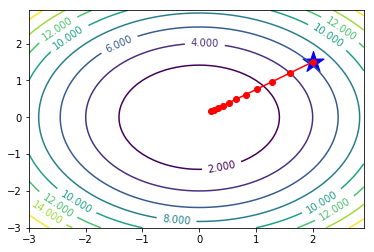

In [165]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_SGD, fn=j1, lr=0.1, coords=coords, steps=10)

### Momentum

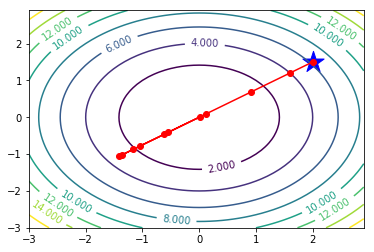

In [166]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_Momentum, fn=j1, lr=0.1, coords=coords, steps=10)

### NAG

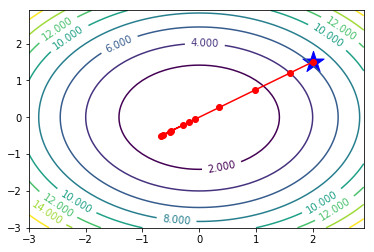

In [175]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_NAG, fn=j1, lr=0.1, coords=coords, steps=10)

### Adagrad

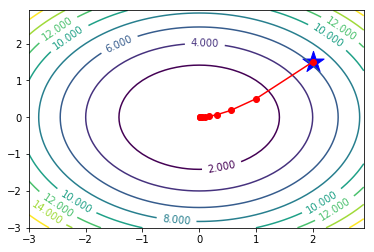

In [16]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_Adagrad, fn=j1, lr=1, coords=coords, steps=10)

### Adadelta

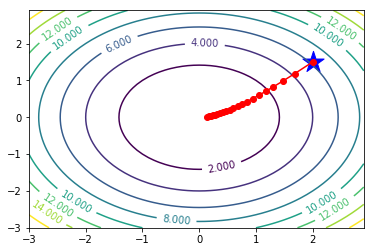

In [17]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_Adadelta, fn=j1, lr=0.1, coords=coords, steps=20)

### Adam

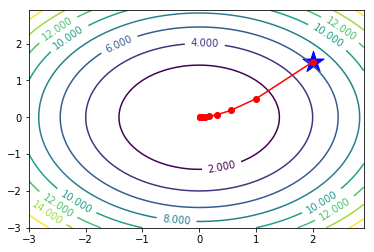

In [153]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_Adam, fn=j1, lr=1, coords=coords, steps=10)

# Функция 2

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [19]:
def j2(X,Y):
    return X**2 * torch.sin(X) + Y**2 * torch.sin(Y)

In [20]:
coords0 = Variable(torch.Tensor([2,1.5]),requires_grad=True)

### SGD

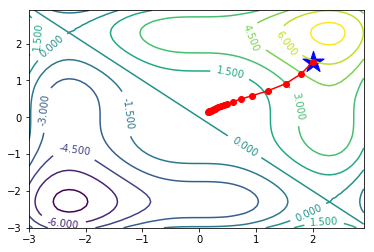

In [176]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_SGD, fn=j2, lr=0.1, coords=coords, steps=20)

### Momentum

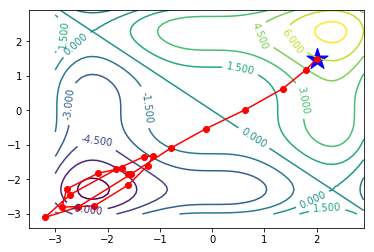

In [267]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_Momentum, fn=j2, lr=0.1, coords=coords, steps=20)

### NAG

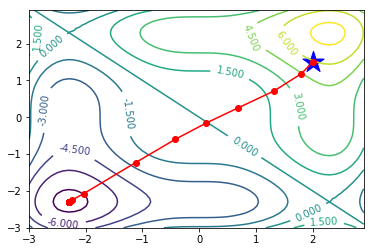

In [268]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_NAG, fn=j2, lr=0.1, coords=coords, steps=20)

### Adagrad

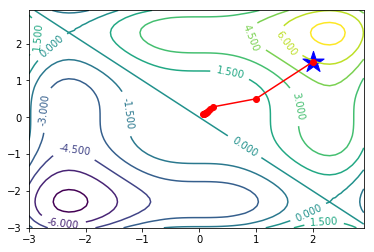

In [24]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_Adagrad, fn=j2, lr=1, coords=coords, steps=10)

### Adadelta

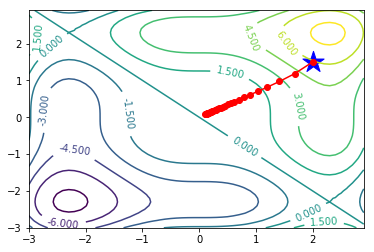

In [25]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_Adadelta, fn=j2, lr=0.1, coords=coords, steps=30)

### Adam

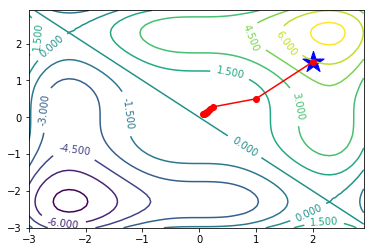

In [179]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_Adam, fn=j2, lr=1, coords=coords, steps=10)

## Функция 3

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [27]:
def j3(X,Y):
    return X**2 * torch.sin(X**2) + Y**2 * torch.sin(Y**2)

In [28]:
coords0 = Variable(torch.Tensor([2,1.5]),requires_grad=True)

### SD

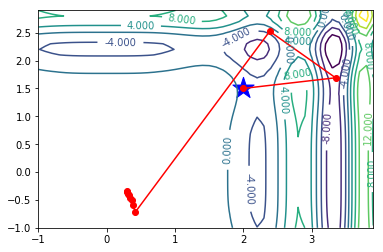

In [29]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_SGD, fn=j3, lr=0.1, coords=coords, steps=10, xlim=(-1,4), ylim=(-1,3))

### Momentum

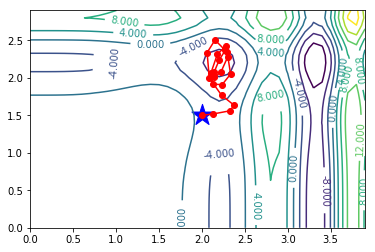

In [30]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_Momentum, fn=j3, lr=0.01, coords=coords, steps=20, xlim=(0,4), ylim=(0,3))

### NAG

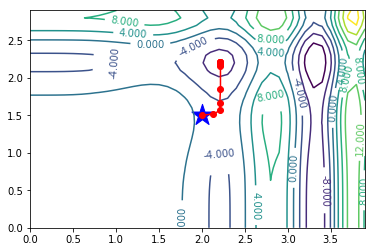

In [31]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_NAG, fn=j3, lr=0.01, coords=coords, steps=10, xlim=(0,4), ylim=(0,3))

### Adagrad

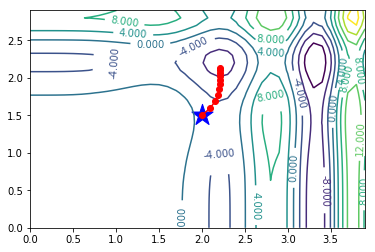

In [32]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_Adagrad, fn=j3, lr=0.1, coords=coords, steps=10, xlim=(0,4), ylim=(0,3))

### Adadelta

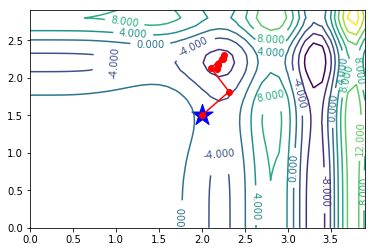

In [33]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_Adadelta, fn=j3, lr=0.1, coords=coords, steps=10, xlim=(0,4), ylim=(0,3))

### Adam

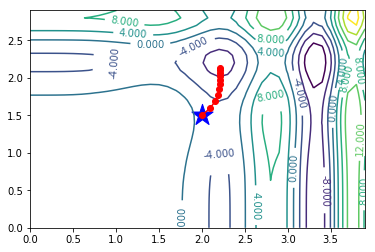

In [34]:
coords = Variable(coords0.data.clone(), requires_grad=True)
plot_optim(optim=My_Adam, fn=j3, lr=0.1, coords=coords, steps=10, xlim=(0,4), ylim=(0,3))

#  Часть 2: Обучение нейронной сети

In [35]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Processing...
Done!


In [36]:
use_cuda = Falseuse_cuda = torch.cuda.is_available() 
if use_cuda:
    torch.cuda.manual_seed(42)
    torch.cuda.set_device(1)
use_cuda

True

for input, target in dataset:
    def closure():
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        return loss
    optimizer.step(closure)


In [238]:
def train(network, train_loader, test_loader, epochs, optim, ravel_init=False):
   
#     def closure():
#             optimizer.zero_grad()
#             prediction = network(X)
#             loss_batch = loss(prediction, y)
#             loss_batch.backward()
#             return loss_batch


    loss = nn.NLLLoss()
    optimizer = optim
    #optimizer = optim(network.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            network.train()
            for X, y in train_loader:
                X = Variable(X)
                y = Variable(y)
            
                if use_cuda:
                    X, y = X.cuda(), y.cuda()
                    
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                loss_batch.backward()
                optimizer.step()
                
                if use_cuda:
                    accuracies.append((np.argmax(prediction.data.cpu().numpy(), 1)==y.data.cpu().numpy()).mean())
                else:
                    accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            
            scheduler.step(loss_batch.data[0])

     
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []  
            network.eval()
            for X, y in test_loader:
                X = Variable(X)
                y = Variable(y)
                
                if use_cuda:
                    X, y = X.cuda(), y.cuda()
                
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                
                if use_cuda:
                    accuracies.append((np.argmax(prediction.data.cpu().numpy(), 1)==y.data.cpu().numpy()).mean())
                else:
                    accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
                
            
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

# Линейная сеть

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [253]:
class network_lin(nn.Module):
    def __init__(self):
        super(network_lin, self).__init__()

        
        self.linear_layers = nn.Sequential(nn.Linear(784, 200),
                                           nn.ReLU(),
                                           
                                           nn.Linear(200, 200),
                                           nn.ReLU(),
                                           
                                           nn.Linear(200, 10),
                                           nn.LogSoftmax(dim=1))
        
        nn.init.xavier_normal(self.linear_layers[0].weight)
        nn.init.xavier_normal(self.linear_layers[2].weight)
        nn.init.xavier_normal(self.linear_layers[4].weight)

    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


## Линейная SGD

In [254]:
network_lin_sgd = network_lin()
if use_cuda:
    network_lin_sgd = network_lin_sgd.cuda()
optim_lin_sgd = torch.optim.SGD(network_lin_sgd.parameters(), lr=0.1)

Epoch 41... (Train/Test) NLL: 0.001/0.086	Accuracy: 1.000/0.981Epoch    42: reducing learning rate of group 0 to 1.0000e-02.
Epoch 49... (Train/Test) NLL: 0.000/0.087	Accuracy: 1.000/0.982

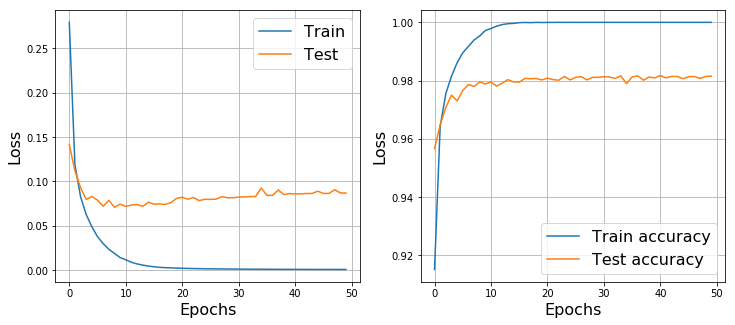

In [256]:
train(network_lin_sgd, train_loader, test_loader, 50, optim_lin_sgd)

## Линейная Momentum

In [257]:
network_lin_momentum = network_conv()
if use_cuda:
    network_lin_momentum = network_lin_momentum.cuda()
optim_lin_momentum = torch.optim.SGD(network_lin_momentum.parameters(), lr=0.1, momentum=0.9)

Epoch 20... (Train/Test) NLL: 0.056/0.071	Accuracy: 0.983/0.982Epoch    21: reducing learning rate of group 0 to 1.0000e-02.
Epoch 43... (Train/Test) NLL: 0.007/0.073	Accuracy: 0.999/0.986Epoch    44: reducing learning rate of group 0 to 1.0000e-03.
Epoch 49... (Train/Test) NLL: 0.005/0.073	Accuracy: 0.999/0.986

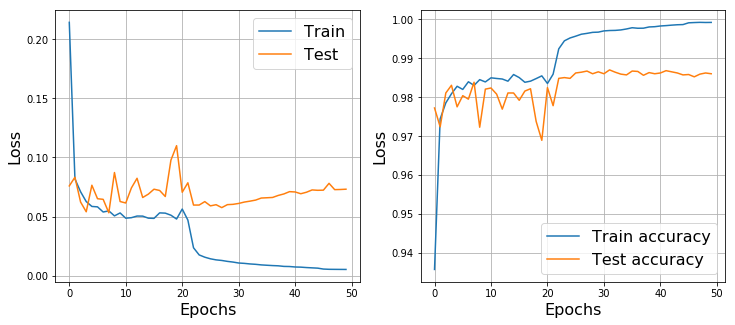

In [258]:
train(network_lin_momentum, train_loader, test_loader, 50, optim_lin_momentum)

## Линейная NAG

In [259]:
network_lin_NAG = network_conv()
if use_cuda:
    network_lin_NAG = network_lin_NAG.cuda()
    
optim_lin_NAG = torch.optim.SGD(network_lin_NAG.parameters(), lr=0.1, momentum=0.9, nesterov=True)

Epoch 22... (Train/Test) NLL: 0.097/0.104	Accuracy: 0.971/0.968Epoch    23: reducing learning rate of group 0 to 1.0000e-02.
Epoch 33... (Train/Test) NLL: 0.059/0.071	Accuracy: 0.982/0.977Epoch    34: reducing learning rate of group 0 to 1.0000e-03.
Epoch 49... (Train/Test) NLL: 0.054/0.068	Accuracy: 0.984/0.978

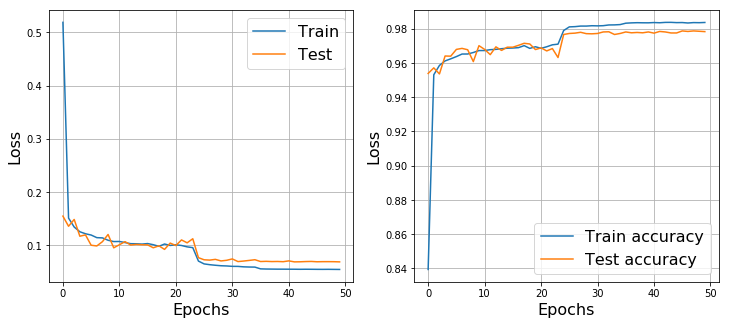

In [260]:
train(network_lin_NAG, train_loader, test_loader, 50, optim_lin_NAG)

## Линейная Adagrad

In [261]:
network_lin_adagrad = network_conv()
if use_cuda:
    network_lin_adagrad = network_lin_adagrad.cuda()
optim_lin_adagrad = torch.optim.Adagrad(network_lin_adagrad.parameters(), lr=0.1)

Epoch 24... (Train/Test) NLL: 0.041/0.061	Accuracy: 0.987/0.981Epoch    25: reducing learning rate of group 0 to 1.0000e-02.
Epoch 43... (Train/Test) NLL: 0.035/0.064	Accuracy: 0.989/0.980Epoch    44: reducing learning rate of group 0 to 1.0000e-03.
Epoch 49... (Train/Test) NLL: 0.034/0.063	Accuracy: 0.989/0.980

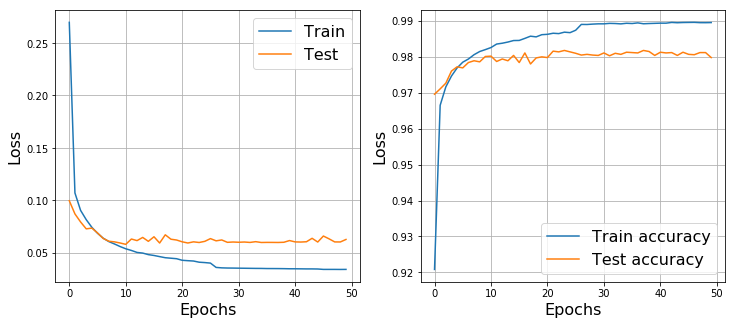

In [262]:
train(network_lin_adagrad, train_loader, test_loader, 50, optim_lin_adagrad)

## Линейная Adadelta

In [263]:
network_lin_adadelta = network_conv()
if use_cuda:
    network_lin_adadelta = network_lin_adadelta.cuda()
optim_lin_adadelta = torch.optim.Adadelta(network_lin_adadelta.parameters(), lr=0.1)

Epoch 17... (Train/Test) NLL: 0.053/0.049	Accuracy: 0.984/0.983Epoch    18: reducing learning rate of group 0 to 1.0000e-02.
Epoch 32... (Train/Test) NLL: 0.045/0.049	Accuracy: 0.987/0.982Epoch    33: reducing learning rate of group 0 to 1.0000e-03.
Epoch 43... (Train/Test) NLL: 0.044/0.049	Accuracy: 0.987/0.982Epoch    44: reducing learning rate of group 0 to 1.0000e-04.
Epoch 49... (Train/Test) NLL: 0.044/0.048	Accuracy: 0.987/0.982

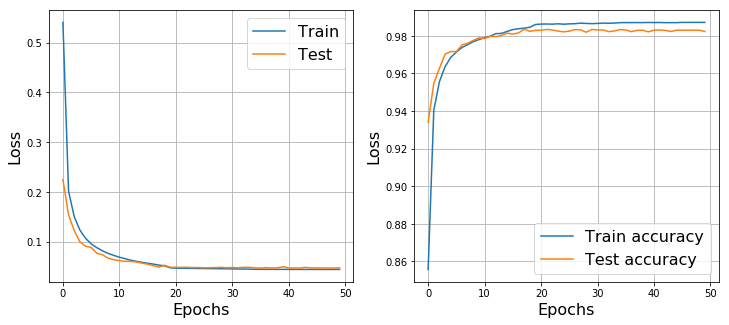

In [264]:
train(network_lin_adadelta, train_loader, test_loader, 50, optim_lin_adadelta)

## Линейная Adam

In [265]:
network_lin_adam = network_conv()
if use_cuda:
    network_lin_adam = network_lin_adam.cuda()
optim_lin_adam = torch.optim.Adam(network_lin_adam.parameters(), lr=0.01)

Epoch 49... (Train/Test) NLL: 0.033/0.154	Accuracy: 0.992/0.982

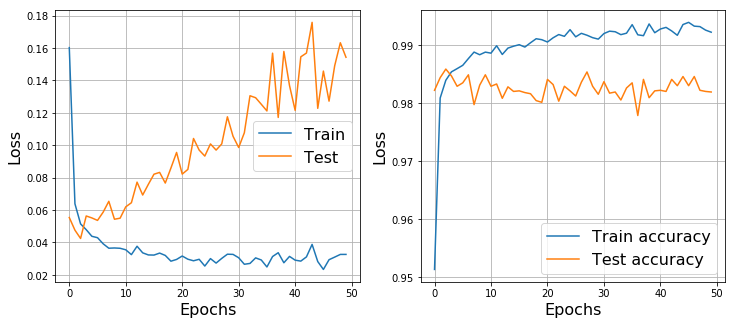

In [266]:
train(network_lin_adam, train_loader, test_loader, 50, optim_lin_adam)

## Сверточная сеть

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [59]:
class network_conv(nn.Module):
    def __init__(self):
        super(network_conv, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 4, 3, padding=1),
                                         nn.MaxPool2d(2),
                                         nn.ReLU(),
                                         
                                         nn.Conv2d(4, 16, 3, padding=1), 
                                         nn.MaxPool2d(2),
                                         nn.ReLU()
                                        )
        
        self.linear_layers = nn.Sequential(nn.Linear(784, 10), 
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

## Сверточная SGD

In [199]:
network_conv_sgd = network_conv()
if use_cuda:
    network_conv_sgd = network_conv_sgd.cuda()
optim_conv_sgd = torch.optim.SGD(network_conv_momentum.parameters(), lr=0.1, momentum=0.1)

Epoch 21... (Train/Test) NLL: 0.030/0.047	Accuracy: 0.990/0.985Epoch    22: reducing learning rate of group 0 to 1.0000e-03.
Epoch 45... (Train/Test) NLL: 0.025/0.041	Accuracy: 0.993/0.987Epoch    46: reducing learning rate of group 0 to 1.0000e-04.
Epoch 49... (Train/Test) NLL: 0.024/0.041	Accuracy: 0.993/0.987

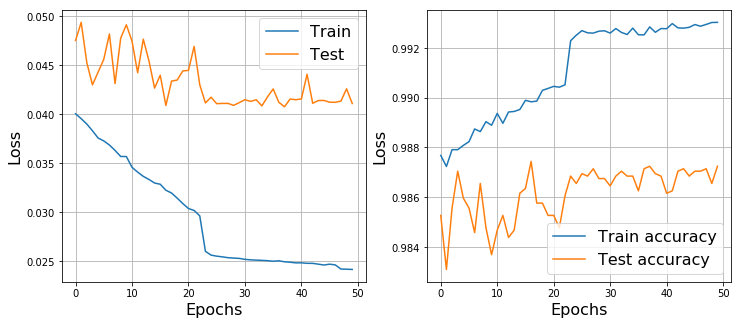

In [181]:
train(network_conv_sgd, train_loader, test_loader, 50, optim_conv_sgd)

## Сверточная Momentum

In [197]:
network_conv_momentum = network_conv()
if use_cuda:
    network_conv_momentum = network_conv_momentum.cuda()
optim_conv_momentum = torch.optim.SGD(network_conv_momentum.parameters(), lr=0.1, momentum=0.1)

Epoch 36... (Train/Test) NLL: 0.012/0.064	Accuracy: 0.996/0.985Epoch    37: reducing learning rate of group 0 to 1.0000e-02.
Epoch 47... (Train/Test) NLL: 0.004/0.057	Accuracy: 0.999/0.987Epoch    48: reducing learning rate of group 0 to 1.0000e-03.
Epoch 49... (Train/Test) NLL: 0.004/0.060	Accuracy: 0.999/0.986

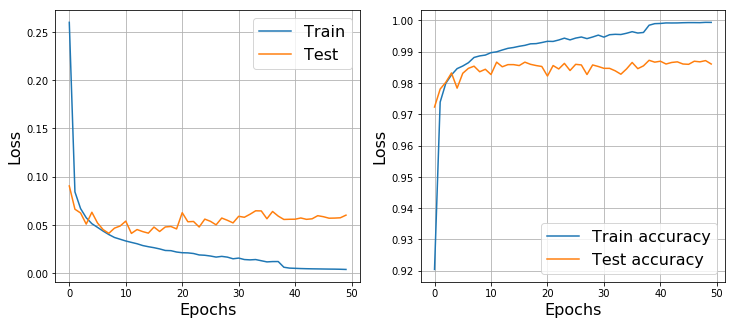

In [198]:
train(network_conv_momentum, train_loader, test_loader, 50, optim_conv_momentum)

## Сверточная NAG

In [220]:
network_conv_NAG = network_conv()
if use_cuda:
    network_conv_NAG = network_conv_NAG.cuda()
    
optim_conv_NAG = torch.optim.SGD(network_conv_NAG.parameters(), lr=0.1, momentum=0.9, nesterov=True)

Epoch 28... (Train/Test) NLL: 0.043/0.075	Accuracy: 0.987/0.981Epoch    29: reducing learning rate of group 0 to 1.0000e-02.
Epoch 49... (Train/Test) NLL: 0.006/0.061	Accuracy: 0.999/0.986

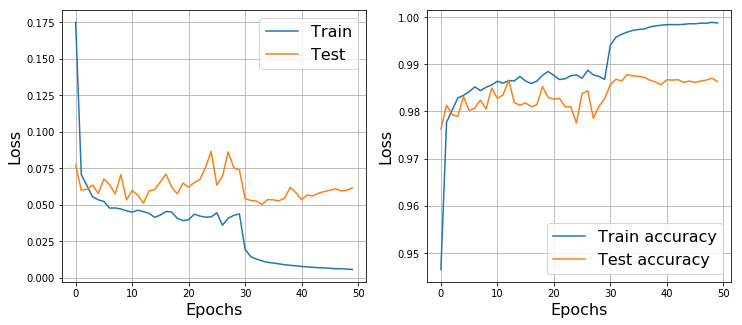

In [243]:
train(network_conv_NAG, train_loader, test_loader, 50, optim_conv_NAG)

## Сверточная Adagrad

In [224]:
network_conv_adagrad = network_conv()
if use_cuda:
    network_conv_adagrad = network_conv_adagrad.cuda()
optim_conv_adagrad = torch.optim.Adagrad(network_conv_adagrad.parameters(), lr=0.1)

Epoch 49... (Train/Test) NLL: 0.009/0.068	Accuracy: 0.998/0.985

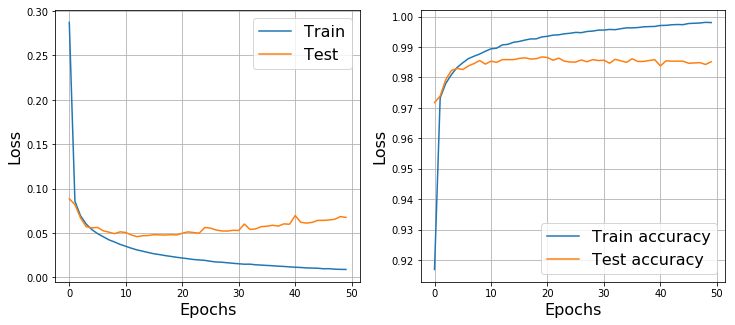

In [225]:
train(network_conv_adagrad, train_loader, test_loader, 50, optim_conv_adagrad)

## Сверточная Adadelta

In [230]:
network_conv_adadelta = network_conv()
if use_cuda:
    network_conv_adadelta = network_conv_adadelta.cuda()
optim_conv_adadelta = torch.optim.Adadelta(network_conv_adadelta.parameters(), lr=0.1)

Epoch 33... (Train/Test) NLL: 0.037/0.041	Accuracy: 0.989/0.986Epoch    34: reducing learning rate of group 0 to 1.0000e-02.
Epoch 44... (Train/Test) NLL: 0.032/0.038	Accuracy: 0.991/0.987Epoch    45: reducing learning rate of group 0 to 1.0000e-03.
Epoch 49... (Train/Test) NLL: 0.032/0.038	Accuracy: 0.991/0.988

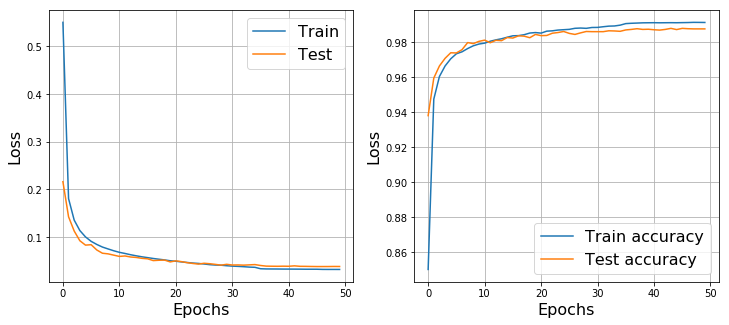

In [231]:
train(network_conv_adadelta, train_loader, test_loader, 50, optim_conv_adadelta)

## Сверточная Adam

In [241]:
network_conv_adam = network_conv()
if use_cuda:
    network_conv_adam = network_conv_adam.cuda()
optim_conv_adam = torch.optim.Adam(network_conv_adam.parameters(), lr=0.01)

Epoch 49... (Train/Test) NLL: 0.029/0.106	Accuracy: 0.993/0.984

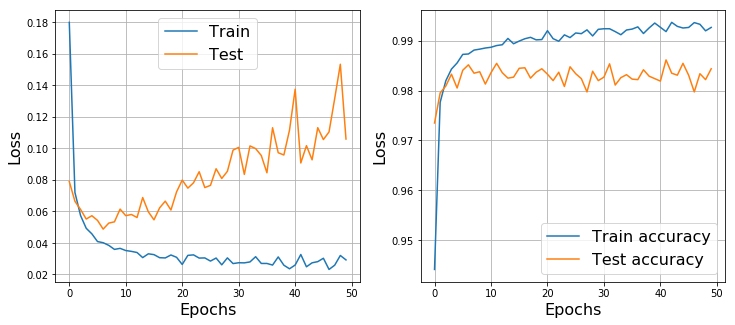

In [242]:
train(network_conv_adam, train_loader, test_loader, 50, optim_conv_adam)